# Question

Better investment decisions:
Identify new features from demographic trends (population incomes and employment are already identified) for regional property investments for self-storage businesses.


# Approach
Since the financial performance of regional storages aren't given, which can be the ideal predictand, let's make some assumptions for the predictand:
  1. Assume uniform financial model (loss, cost, net gross profit, etc) for all units, and `accumulate the net cashflow by region`. Treat the problem as a multilinear regression problem by economic/demographic features predicting net cashflow. 
    - challenge is to define regions so to match the stats from the source we download the economic/demographic data.
  2. Treat either regional population incomes or employment as the predictand since these are identified as good investment indicators for self-storage businesses. This will also allow continuous data modelling from the stats downloadable tables. This can become a multi-linear regression problem.
    - challenge is we might be building a good model for predicting regional incomes or employments, instead of self-storage investment returns.
  3. Use the table's given locations as good investment instances (1), and define the not given locations as bad investment instances (0). This will be a binary classification problem.
    - challenge is to obtain the bad investment locations, which have the possibility of including potentially good locations.

Let's settle on the assumption 1.




# Feature acquisition

## Understanding the financial model
- The size of the property (rentable + non-rentable) of Table 1 is `450000/9 = 50000` square feet.

- Total gross annual income is `$472.5K` and `$9` per SF composed of two parts as a percentage of gross:
    - Rent is about `95%`
    - other incomes (source in question) is about `5%`. 

- Since rent accounts for `95%` of the income, and consider the market share of PS, we really want to focus on **finding the demographic features that will boost the `annual rent`**. Let's put aside the source of other incomes for this project due to time limit.

- The effective gross annual income is `$425.25K` after subtracting the `10%` loss by vacancy and collections. We don't want to assume `100%` occupancy. At the same time we might want to reduce the vacancy to boost the `annual rent`. Let's assume all `10%` of loss is by vacancy, and suppose the vancancy was reduced by `10%`. That translates to a `1%` gain by rent, which is pretty significant. Therefore **search for the features that reduces the vacancy**.

- The annual expense as a percentage of the effective gross is composed of two parts: 
    - operating expense (source in question) is about `-33%`. 
    - debt service is about `-39%`. 
    
- The net cashflow before-tax is about `+28%` of effective gross.

- Let's assume the debt service is uniform throughout the country. Here leads to the main question of finding the source of "operating expense" which can be broken down to: 
    - on-site or off-site management salaries, 
    - real estate taxes, 
    - insurance (building, liability, tenant, etc), 
    - repair and maintenance, utility (water, sewage, electricity), 
    - administration (phone, postage, bank charges, credit reports, legal services, data processing, etc), 
    - advertising.

 
## Developmental Cost 
The majority of the cost lies in two targets:
- Land: the cost of land can really well relate to construction cost
- construction & security:
  - labor, 
  - weather variables (can be a predictor of climate controlled units at PS, e.g., humidity),
  - removal of trees (GIS data of landscape),
  - digging through dirt or stone

## Regional economic factors
As mentioned, the downturn and recovery phase of the economy can create opportunities for self-storage business, e.g., increasing the rent with higher moving rate. Here are few interesting features:
- Population mobility
- Consumer spending 
  - gasoline (high price can create opportunity for construction car parking)
  - housing & vehicles
  - utilities
  - healthcare
  - retail sales
- Businesses that uses PS
  - startups (move-in, move-out, office supplies)
  - contruction 
  - commerce 
  - delivery services
  - real estate developers
  - gas, oil, energy
  

## Goal
We want to acquire features that achieves the following goal to increase profitability:
 - reduce the vacancy
 - boost the annual rent
 - reduce the operating expense
 - reduce the land and construction cost
 - trace regional economy 

# Data acquisition

Let's define each location with net profit of 1 unit and count number of properties over the region. We assumed companies have no difference on the unit profit, so we only care about predicting regional profitability for the self-storage business as a whole. 

Let's use states as the geographical constraint on getting the regional economic/demographic data.

The BEA websites regional econonomics data are on a state level (https://github.com/davidrpugh/pyBEA/blob/master/examples/user-guide.ipynb)

In [582]:
import importlib
from matplotlib import pyplot as plt

In [1386]:
import requests
import numpy as np
import threading
base_url = 'https://apps.bea.gov/api/data'
# the column dictionary with linecode for the BEA API
columnLinecode = {'farmEarning':81, 'forestryFishing':100, 'miningQuarryingOilGas':200,
           'utilities':300, 'construction':400, 'manufacturing':500, 
           'durableGoodsManufacturing':510, 'nondurableGoodsManufacturing':530, 
           'wholesaleTrade':600,
           'retailTrade':700,
           'transportWarehousing':800,
           'info':900,
           'finInsurance':1000,
           'realEstRentLeasing':1100, 
           'profSciTechServices': 1200,
           'manageCompaniesEnterprises': 1300,
           'adminSuppWasteRemedServices': 1400,
           'edu': 1500,
           'healthSocAssist': 1600,
           'artsEntertainRec': 1700,
           'accomFoodServices': 1800,
           'fedCivilian': 2001,
           'militart': 2002,
           'stateLocal':2010}
columnLinecode_inv = {val: key for key, val in columns.items()}  # the inverse mapping of linecode to industry name       
def param(USER_ID, linecode):
    '''
    the parameters for the API request
    '''
    return {'UserID':USER_ID, 
            'DatasetName':'Regional',
            'TableName':'SQINC5N', # Personal Income by Major Component and Earnings by NAICS Industry
#            'Frequency':['Y'],
            #'YEAR':'ALL',      
#            'GeoFips':'COUNTY',
            'GeoFips':'STATE',      
            'LineCode': linecode,                                   
            'Method':'GetData', 
#            'Method':'GetParameterList',       
            'ResultFormat':'JSON'}

def requestDF(base_url, USER_ID, linecode):
    '''
    Function for multi-threading requesting the BEA data by linecode
    return: the dataframe with DataValue
    '''
    response = requests.get(base_url, param(USER_ID, linecode))
    return (pd.DataFrame(response.json()['BEAAPI']['Results']['Data'], 
                                       columns = ["DataValue"]), linecode)
def requestJSON(base_url, USER_ID, linecode):
    '''
    Function for multi-threading requesting the BEA data by linecode
    return: a list with DataValue
    '''
    response = requests.get(base_url, param(USER_ID, linecode))
    return [columnLinecode_inv[linecode], 
            [row['DataValue'] for row in response.json()['BEAAPI']['Results']['Data']]]
    
def ListToJSON(queue):
    '''
    return JSON format from the multi-threaded queue for spark to dataframe
    args:
      :queue: [["a", [1,2,3]], ["b", [1,2,4]]]
    return:
      :res: [{"a":1,"b":1}, {"a":2,"b":2}, {"a":3, "b":4}]
    '''
    res = []
    cols = [q[0] for q in queue]
    for vals in zip(*(q[1] for q in queue)):
        tmp = {}
        for k, v in zip(cols, vals):
            tmp[k] = v
        res.append(tmp)
    return res



In [ ]:
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark import SparkContext

# apply multi-threading to make API requests for Spark Dataframe
threads = []
queue = []
for linecode in columnLincode.values():
#    t = threading.Thread(target=lambda q, arg: q.append(requestDF(*arg)), 
    t = threading.Thread(target=lambda q, arg: q.append(requestJSON(*arg)), 
                         args=[queue, (base_url, USER_ID, linecode)])
    t.start()
    threads.append(t)
for t in threads:
    t.join()

# transform to json     
queue_spark = ListToJSON(queue)

# create spark dataframe using 2 local clusters
spark.stop() # stop the previous session to recreate a new sparkSession
conf = SparkConf().setAppName("test").setMaster("local[2]") # use 2 cores, use all available cores by `local[*]`, or 1 core by `local`.
sc = SparkContext(conf=conf)
spark = SparkSession.builder.config(conf=conf).getOrCreate()
json_rdd = sc.parallelize(queue_spark)
df = spark.read.json(json_rdd)
#df.show(truncate=False)

In [1419]:
df.show(1)

+-----------------+---------------------------+----------------+------------+-------------------------+-----------+-----------+-----------+------------+---------------+---------------+-----------+--------------------------+-------------+-----------+---------------------+----------------------------+-------------------+------------------+-----------+-------------+--------------------+----------+--------------+
|accomFoodServices|adminSuppWasteRemedServices|artsEntertainRec|construction|durableGoodsManufacturing|        edu|farmEarning|fedCivilian|finInsurance|forestryFishing|healthSocAssist|       info|manageCompaniesEnterprises|manufacturing|   militart|miningQuarryingOilGas|nondurableGoodsManufacturing|profSciTechServices|realEstRentLeasing|retailTrade|   stateLocal|transportWarehousing| utilities|wholesaleTrade|
+-----------------+---------------------------+----------------+------------+-------------------------+-----------+-----------+-----------+------------+---------------+------

In [1295]:
# apply multi-threading to make API requests for Pandas Dataframe
threads = []
queue = []
for linecode in columnLincode.values():
#    t = threading.Thread(target=lambda q, arg: q.append(requestDF(*arg)), 
    t = threading.Thread(target=lambda q, arg: q.append(requestDf(*arg)), 
                         args=[queue, (base_url, USER_ID, linecode)])
    t.start()
    threads.append(t)
for t in threads:
    t.join()
    
# obtain the data pushed to the queue requested from the multi-threaded API return
response = requests.get(base_url, param(USER_ID, 20))
dfs = pd.DataFrame(response.json()['BEAAPI']['Results']['Data'], 
                columns = ["GeoName","TimePeriod"])
industry_columns = []
for data, linecode in queue:
    industry_columns.append(columns_inv[linecode])
    dfs = pd.concat([dfs, data], axis=1, sort=False)
dfs.columns = ["GeoName","TimePeriod"] + list(industry_columns) # assign the column names to the dataset     

In [1418]:
# alternatively transform pandas to spark 
#spark_df = spark.createDataFrame(dfs)

In [1302]:
# check the combined data from API request
dfs

,GeoName,TimePeriod,finInsurance,info,wholesaleTrade,realEstRentLeasing,militart,profSciTechServices,forestryFishing,construction,...,retailTrade,utilities,fedCivilian,stateLocal,accomFoodServices,edu,adminSuppWasteRemedServices,manageCompaniesEnterprises,miningQuarryingOilGas,healthSocAssist
0,United States,1998Q1,"925,290,000","196,249,164","295,105,452","112,454,756","145,409,800","449,043,464","32,148,300","831,788,500",...,"749,226,700","42,445,120","159,857,300","678,941,500","175,994,552","225,942,900","192,360,348","356,080,800","45,478,836","495,532,332"
1,United States,1998Q2,"965,804,400","202,636,940","300,443,856","116,100,024","149,841,000","463,501,264","17,758,100","777,625,800",...,"688,170,700","42,138,532","160,746,816","689,546,332","180,500,592","198,537,300","197,184,076","346,212,300","45,221,028","497,769,732"
2,United States,1998Q3,"355,120,028","205,633,124","305,443,436","120,282,036","60,682,616","479,761,872","17,955,900","331,808,440",...,"405,551,264","42,401,568","162,717,912","699,847,924","185,205,332","64,777,520","203,700,840","113,712,560","45,412,980","506,327,336"
3,United States,1998Q4,"366,840,072","210,104,772","307,675,256","123,123,184","60,628,308","494,357,400","18,293,888","339,711,360",...,"413,619,880","43,182,780","164,185,972","709,140,244","189,119,524","65,205,700","209,134,736","115,442,276","45,311,156","513,342,600"
4,United States,1999Q1,"374,211,108","224,257,172","310,845,648","129,676,824","60,861,612","500,251,668","18,512,112","352,530,468",...,"420,593,616","43,976,308","164,049,184","719,453,152","189,522,696","67,258,140","212,756,596","117,151,808","43,714,348","515,523,888"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5395,Far West,2019Q2,"123,348,044","174,275,156","100,201,028","83,386,532","32,100,948","293,304,692","16,032,616","153,625,648",...,"119,036,248","19,989,492","51,271,920","339,575,444","106,957,500","30,882,764","54,458,144","60,542,932","8,830,104","247,695,516"
5396,Far West,2019Q3,"122,942,308","172,856,136","99,819,532","84,649,480","32,396,364","293,879,468","16,154,752","155,467,664",...,"120,696,844","19,946,424","51,640,836","343,837,288","107,729,164","31,185,592","55,254,636","59,832,372","8,553,292","250,586,376"
5397,Far West,2019Q4,"126,464,620","179,045,460","99,762,852","86,912,828","32,446,244","298,790,996","16,733,544","158,033,032",...,"123,516,160","20,475,108","52,149,448","348,768,548","109,039,040","31,426,684","54,392,564","61,271,028","8,497,444","254,364,620"
5398,Far West,2020Q1,"128,797,985","184,161,317","101,161,068","87,696,406","32,123,309","310,804,815","16,970,963","161,451,109",...,"124,178,332","20,601,074","52,806,193","350,137,220","108,585,068","31,359,396","56,035,252","60,193,322","8,257,531","258,276,177"


In [1177]:
dfs.isna().sum() # this won't show (NA) since it's string

GeoName                         0
TimePeriod                      0
manufacturing                   0
finInsurance                    0
miningQuarryingOilGas           0
realEstRentLeasing              0
militart                        0
transportWarehousing            0
utilities                       0
farmEarning                     0
fedCivilian                     0
nondurableGoodsManufacturing    0
profSciTechServices             0
accomFoodServices               0
edu                             0
info                            0
manageCompaniesEnterprises      0
healthSocAssist                 0
durableGoodsManufacturing       0
adminSuppWasteRemedServices     0
retailTrade                     0
forestryFishing                 0
artsEntertainRec                0
wholesaleTrade                  0
construction                    0
stateLocal                      0
dtype: int64

In [1181]:
def strToInt(x):
    '''
    Remove the commas in the number
    '''
    x = str.replace(x,',','')
    try:
        return int(x)
    except Exception:
        return None
numeric = dfs.iloc[:, 2:].applymap(lambda x: strToInt(x))
numeric_normalized = numeric.div(numeric.sum(axis=1, skipna=True), axis=0)*100

def removeQ(x):
    '''
    remove the quarter
    '''
    return x[:-2]
newtime = dfs[['TimePeriod']].applymap(lambda x: removeQ(x)).astype(float)


In [1182]:
# total number of nans for each feature
numeric_normalized.isna().sum()


manufacturing                    34
finInsurance                      0
miningQuarryingOilGas           324
realEstRentLeasing                0
militart                          0
transportWarehousing             48
utilities                        56
farmEarning                       0
fedCivilian                       0
nondurableGoodsManufacturing     80
profSciTechServices               0
accomFoodServices                16
edu                               0
info                             40
manageCompaniesEnterprises        0
healthSocAssist                   0
durableGoodsManufacturing        80
adminSuppWasteRemedServices       0
retailTrade                       0
forestryFishing                 316
artsEntertainRec                  0
wholesaleTrade                    0
construction                     40
stateLocal                        0
dtype: int64

In [1183]:
df_industry = pd.concat([dfs.GeoName, newtime, numeric_normalized], axis=1, sort=False)

In [1193]:
grouped_industry = df_industry.groupby(['GeoName','TimePeriod']).mean() # average percentage of earnings per time period per geoName

industry = grouped_industry.reset_index()
industry_unimp = industry.copy() # the unimputed original dataframe

In [1194]:
# the total number of nans after aggregation
industry_unimp.isna().sum()

GeoName                          0
TimePeriod                       0
manufacturing                    6
finInsurance                     0
miningQuarryingOilGas           81
realEstRentLeasing               0
militart                         0
transportWarehousing            11
utilities                       12
farmEarning                      0
fedCivilian                      0
nondurableGoodsManufacturing    18
profSciTechServices              0
accomFoodServices                3
edu                              0
info                             9
manageCompaniesEnterprises       0
healthSocAssist                  0
durableGoodsManufacturing       18
adminSuppWasteRemedServices      0
retailTrade                      0
forestryFishing                 79
artsEntertainRec                 0
wholesaleTrade                   0
construction                     9
stateLocal                       0
dtype: int64

In [1195]:
# drop all the nans
industry = industry.dropna()

In [1186]:
grouped_industry

manufacturing  finInsurance  miningQuarryingOilGas  \
GeoName TimePeriod                                                       
Alabama 1998.0          16.695345      3.767099               0.857142   
        1999.0          16.322730      3.827782               0.781991   
        2000.0          15.963946      3.912209               0.697248   
        2001.0          15.945245      4.250561               0.660604   
        2002.0          14.989655      4.299677               0.633456   
...                           ...           ...                    ...   
Wyoming 2016.0           4.206974      2.562493              12.400478   
        2017.0                NaN      2.983684              14.141687   
        2018.0           4.302416      2.533943              15.648473   
        2019.0           4.452805      2.606696              11.443636   
        2020.0           4.407321      2.653789              12.250238   

                    realEstRentLeasing  militart  transportWarehousing  \
GeoName TimePeriod                                                       
Alabama 1998.0                1.067171  1.285240              3.072384   
        1999.0                1.123733  1.214089              2.987189   
        2000.0                1.137303  1.152779              3.020033   
        2001.0                1.158982  1.233505              2.938496   
        2002.0                1.196150  1.402616              2.812245   
...                                ...       ...                   ...   
Wyoming 2016.0                3.127152  1.706756              6.132143   
        2017.0                2.909304  1.966075              8.317077   
        2018.0                2.594728  1.769256              8.267280   
        2019.0                2.647519  1.811180              9.874299   
        2020.0                2.589336  1.891358              9.231649   

                    utilities  farmEarning  fedCivilian  \
GeoName TimePeriod                                        
Alabama 1998.0       1.175964     1.293515     3.754049   
        1999.0       1.176397     1.440529     3.576227   
        2000.0       1.208530     1.077924     3.683370   
        2001.0       1.488884     1.558582     3.708955   
        2002.0       1.401808     1.056159     3.838902   
...                       ...          ...          ...   
Wyoming 2016.0       0.714349     0.839873     3.347738   
        2017.0            NaN     1.006600     3.838200   
        2018.0       0.822732     1.071138     3.428282   
        2019.0       0.894910     1.046779     3.410660   
        2020.0       0.929712     1.001020     3.547543   

                    nondurableGoodsManufacturing  ...  \
GeoName TimePeriod                                ...   
Alabama 1998.0                          7.302652  ...   
        1999.0                          7.014759  ...   
        2000.0                          6.870321  ...   
        2001.0                          6.762921  ...   
        2002.0                          6.030860  ...   
...                                          ...  ...   
Wyoming 2016.0                          2.740158  ...   
        2017.0                               NaN  ...   
        2018.0                          2.570686  ...   
        2019.0                          2.592366  ...   
        2020.0                          2.642844  ...   

                    manageCompaniesEnterprises  healthSocAssist  \
GeoName TimePeriod                                                
Alabama 1998.0                        0.565127         7.844075   
        1999.0                        0.575575         7.656747   
        2000.0                        0.548040         7.877003   
        2001.0                        0.665072         8.232605   
        2002.0                        0.671364         8.501334   
...                                        ...              ...   
Wyoming 2016.0                        0.348396  

In [1187]:
# seems like a grouped linear regression over time can resolve the missing value
# linearly interpolate the values for each state's missing value
from scipy import interpolate
def interp(df, i, j):
    '''
    Interpolate the NaN values with nearby values
    CAUTION: This should be done more carefully to use state as condition for interpolation
    '''
    return df.loc[i,j] # just a placeholder for future rigorous interpolation
    #return max(df.loc[i-1,j], df.loc[i+1,j], 0) # interpolate eithe the lead or trail val

for i in industry.index:
    for j in industry.columns:
        if type(industry.loc[i,j])==np.float64 and np.isnan(industry.loc[i,j]):
            industry.loc[i,j] = interp(industry, i, j)#.replace({j:i}, interp(industry, i, j))


In [1196]:
industry.isna().sum() # all nans are replace by interpolation

GeoName                         0
TimePeriod                      0
manufacturing                   0
finInsurance                    0
miningQuarryingOilGas           0
realEstRentLeasing              0
militart                        0
transportWarehousing            0
utilities                       0
farmEarning                     0
fedCivilian                     0
nondurableGoodsManufacturing    0
profSciTechServices             0
accomFoodServices               0
edu                             0
info                            0
manageCompaniesEnterprises      0
healthSocAssist                 0
durableGoodsManufacturing       0
adminSuppWasteRemedServices     0
retailTrade                     0
forestryFishing                 0
artsEntertainRec                0
wholesaleTrade                  0
construction                    0
stateLocal                      0
dtype: int64

Text(0.5, 0, 'samples')

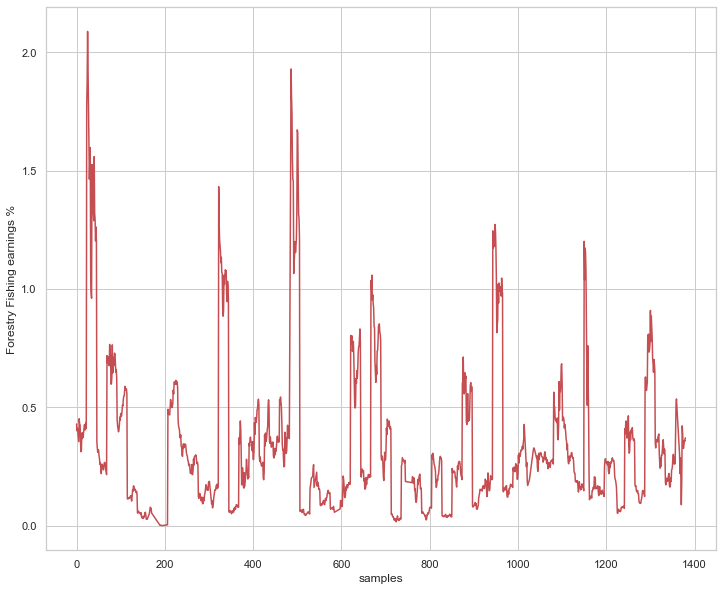

In [1197]:
# let's check how good the imputation looks before and after imputating
# the missing value
plt.figure(figsize=(12,10))
plt.plot(industry.forestryFishing,'r')
# the blue * represents the imputed values
plt.plot(industry.forestryFishing[industry_unimp.forestryFishing.isna()],'b*')
plt.ylabel('Forestry Fishing earnings %')
plt.xlabel('samples')
# the interpolations seems fine

In [504]:
# load the data for the property locations
df_property = pd.read_csv('property_locations.csv')

In [1192]:
df_property

,Market,"Owner/Operator, Franchise",ADDRESS,CTY,ST,Zip,Area,Year
0,Albuquerque,Extra Space Storage,1522 Pacheco Street,Santa Fe,NM,87505,73934.0,2000.0
1,Albuquerque,Extra Space Storage,1909 Golf Course Road SE,Rio Rancho,NM,87124,72836.0,2000.0
2,Albuquerque,Extra Space Storage,3300 Calle Cuervo NW,Albuquerque,NM,87114,80889.0,1998.0
3,Albuquerque,Extra Space Storage,9831 Montgomery Blvd NE,Albuquerque,NM,87111,62697.0,1997.0
4,Albuquerque,Extra Space Storage,9221 Eagle Ranch Road NW,Albuquerque,NM,87114,60821.0,1998.0
...,...,...,...,...,...,...,...,...
4426,Winston-Salem - Greensboro,Public Storage,4605 West Market Street,Greensboro,NC,27407,65399.0,1973.0
4427,Winston-Salem - Greensboro,Public Storage,3010 Electra Drive,Greensboro,NC,27405,50480.0,1973.0
4428,Winston-Salem - Greensboro,Public Storage,3206 North OHenry Blvd,Greensboro,NC,27405,37920.0,1983.0
4429,Worcester - Springfield,Public Storage,31 Jamrog Drive,Chicopee,MA,1020,72605.0,1987.0


In [556]:
# create a state map to create a joining column for the property table
stateMap = {'AL':'Alabama', 'AZ':'Arizona', 'CA':'California',
       'CO':'Colorado', 'CT':'Connecticut', 'DC':'District of Columbia', 'DE':'Delaware',
       'FL':'Florida', 'GA':'Georgia', 'HI':'Hawaii',
       'IL':'Illinois', 'IN':'Indiana', 'IA':'Iowa', 'KS':'Kansas', 'KY':'Kentucky',
       'LA':'Louisiana', 'MD':'Maryland', 'MA':'Massachusetts', 'MI':'Michigan',
       'MN':'Minnesota', 'MS':'Mississippi', 'MO':'Missouri', 'NE':'Nebraska',    
       'NV':'Nevada', 'NH':'New Hampshire', 'NJ':'New Jersey',
       'NM':'New Mexico', 'NY':'New York', 'NC':'North Carolina', 'OH':'Ohio',
       'OK':'Oklahoma', 'OR':'Oregon', 'PA':'Pennsylvania', 'RI':'Rhode Island',
       'SC':'South Carolina', 'TN':'Tennessee', 'TX':'Texas', 'UT':'Utah',
       'VA':'Virginia', 'WA':'Washington', 'WI':'Wisconsin',  
           }
state = df_property[['ST']].applymap(lambda x: stateMap[x])
year = df_property[['Year']]
df_property_final = pd.concat([df_property.iloc[:,1], state, year], axis=1, sort=False)

In [585]:
# aggregate and get the count of properties in each state per year
grouped_property = df_property_final.groupby(['ST','Year']).count()
properties = grouped_property.reset_index().rename(columns={'Owner/Operator, Franchise':'properties'})
# let's assume the earnings of all industry are consistent 
# 3 years prior to 1998 (missing data before 1998 in the BEA database)
properties

,ST,Year,properties
0,Alabama,1974.0,2
1,Alabama,1977.0,1
2,Alabama,1979.0,1
3,Alabama,1980.0,2
4,Alabama,1981.0,1
...,...,...,...
1141,Wisconsin,1988.0,5
1142,Wisconsin,1989.0,1
1143,Wisconsin,1998.0,1
1144,Wisconsin,1999.0,3


In [1198]:
# time to join the two tables (industry and properties)
propertyIndustry = pd.merge(properties, industry, how='inner', on=None, 
         left_on=['ST','Year'], right_on=['GeoName','TimePeriod'],
         left_index=False, right_index=False, sort=False,
         suffixes=('_x', '_y'), copy=True, indicator=False,
         validate=None)
propertyIndustry

,ST,Year,properties,GeoName,TimePeriod,manufacturing,finInsurance,miningQuarryingOilGas,realEstRentLeasing,militart,...,manageCompaniesEnterprises,healthSocAssist,durableGoodsManufacturing,adminSuppWasteRemedServices,retailTrade,forestryFishing,artsEntertainRec,wholesaleTrade,construction,stateLocal
0,Alabama,1998.0,1,Alabama,1998.0,16.695345,3.767099,0.857142,1.067171,1.285240,...,0.565127,7.844075,9.392694,2.281024,6.659903,0.429182,0.367948,4.612690,5.791105,11.643782
1,Alabama,1999.0,2,Alabama,1999.0,16.322730,3.827782,0.781991,1.123733,1.214089,...,0.575575,7.656747,9.307971,2.378096,6.758168,0.400346,0.372763,4.530215,6.118995,11.979262
2,Alabama,2003.0,1,Alabama,2003.0,14.374882,4.436966,0.614318,1.221422,1.626684,...,0.815800,8.477780,8.634286,2.630498,6.604746,0.354588,0.383523,4.540712,6.036759,12.941748
3,Alabama,2004.0,1,Alabama,2004.0,14.334134,4.362176,0.563998,1.255289,1.689789,...,0.900245,8.620020,8.830933,2.672576,6.496402,0.451245,0.360922,4.457815,5.833379,12.695588
4,Arizona,1998.0,5,Arizona,1998.0,11.541025,5.525135,0.686705,1.153926,1.074531,...,1.192666,8.036744,9.848037,4.698160,8.087451,0.353378,1.216897,5.210742,7.541088,11.582602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444,Washington,2019.0,1,Washington,2019.0,8.270061,3.554540,0.146985,2.204852,1.710729,...,1.780885,9.301900,6.444234,3.383863,8.245040,0.684139,0.925294,3.793032,6.650990,12.202221
445,Washington,2020.0,1,Washington,2020.0,7.797164,3.763802,0.130843,2.231530,1.775843,...,1.662031,9.148405,5.969669,3.415558,8.546219,0.655355,0.625565,3.793016,6.619416,12.243710
446,Wisconsin,1998.0,1,Wisconsin,1998.0,20.066948,4.150906,0.114260,0.899005,0.183240,...,1.523935,7.531439,13.051180,2.207608,5.932423,0.183123,0.539872,3.961462,4.909208,10.062564
447,Wisconsin,1999.0,3,Wisconsin,1999.0,19.614456,4.370306,0.108585,0.905127,0.182688,...,1.549648,7.508580,12.662576,2.249444,6.108360,0.171960,0.588051,3.920193,5.230416,10.189733


In [1200]:
print(propertyIndustry.ST.nunique(), properties.ST.nunique())
# this shows that merging didn't remove the number of states in the historical data
# reason to check this is to check that all states are still developing after 
# the missing years before 1998 (BEA dataset limitation)

41 41


In [1199]:
# let's do some EDA on this newly created dataset, cleaning, imputations
propertyIndustry.isna().sum()
# no missing values 

ST                              0
Year                            0
properties                      0
GeoName                         0
TimePeriod                      0
manufacturing                   0
finInsurance                    0
miningQuarryingOilGas           0
realEstRentLeasing              0
militart                        0
transportWarehousing            0
utilities                       0
farmEarning                     0
fedCivilian                     0
nondurableGoodsManufacturing    0
profSciTechServices             0
accomFoodServices               0
edu                             0
info                            0
manageCompaniesEnterprises      0
healthSocAssist                 0
durableGoodsManufacturing       0
adminSuppWasteRemedServices     0
retailTrade                     0
forestryFishing                 0
artsEntertainRec                0
wholesaleTrade                  0
construction                    0
stateLocal                      0
dtype: int64

In [1079]:
# let's check the relationship between variables
#import seaborn as sns
#sns.set(style="whitegrid")
#pp = sns.pairplot(propertyIndustry, vars=['forestryFishing','utilities'], diag_kind='hist')

In [1201]:
from sklearn.feature_extraction import FeatureHasher
h = FeatureHasher(n_features=5, input_type='string')
f = h.transform(propertyIndustry.ST)
stateHash = pd.DataFrame(f.toarray(), columns = ['state0','state1','state2','state3','state4'])
print(stateHash) # 5 columns, originally we have 41 states, one-hot will create too many columns

     state0  state1  state2  state3  state4
0       3.0     0.0     2.0     0.0     0.0
1       3.0     0.0     2.0     0.0     0.0
2       3.0     0.0     2.0     0.0     0.0
3       3.0     0.0     2.0     0.0     0.0
4       1.0    -1.0     1.0     1.0    -1.0
..      ...     ...     ...     ...     ...
444     0.0    -1.0    -1.0     1.0    -5.0
445     0.0    -1.0    -1.0     1.0    -5.0
446     0.0    -2.0    -1.0     1.0    -5.0
447     0.0    -2.0    -1.0     1.0    -5.0
448     0.0    -2.0    -1.0     1.0    -5.0

[449 rows x 5 columns]


In [1246]:
# let's create the final dataset after using featureHasher for the state variable
trainTest = pd.concat([propertyIndustry['properties'], stateHash, propertyIndustry[['Year']]-1998.0, propertyIndustry[['farmEarning',
       'forestryFishing', 'miningQuarryingOilGas', 'utilities', 'construction',
       'manufacturing', 'durableGoodsManufacturing',
       'nondurableGoodsManufacturing', 'wholesaleTrade', 'retailTrade',
       'transportWarehousing', 'info', 'finInsurance', 'realEstRentLeasing',
       'profSciTechServices', 'manageCompaniesEnterprises',
       'adminSuppWasteRemedServices', 'edu', 'healthSocAssist',
       'artsEntertainRec', 'accomFoodServices', 'fedCivilian', 'militart',
       'stateLocal']]], axis=1, sort=False)

In [1247]:
trainTest

,properties,state0,state1,state2,state3,state4,Year,farmEarning,forestryFishing,miningQuarryingOilGas,...,profSciTechServices,manageCompaniesEnterprises,adminSuppWasteRemedServices,edu,healthSocAssist,artsEntertainRec,accomFoodServices,fedCivilian,militart,stateLocal
0,1,3.0,0.0,2.0,0.0,0.0,0.0,1.293515,0.429182,0.857142,...,5.629127,0.565127,2.281024,0.506011,7.844075,0.367948,2.230932,3.754049,1.285240,11.643782
1,2,3.0,0.0,2.0,0.0,0.0,1.0,1.440529,0.400346,0.781991,...,5.790923,0.575575,2.378096,0.534706,7.656747,0.372763,2.290236,3.576227,1.214089,11.979262
2,1,3.0,0.0,2.0,0.0,0.0,5.0,1.358226,0.354588,0.614318,...,6.421715,0.815800,2.630498,0.606030,8.477780,0.383523,2.180262,3.939475,1.626684,12.941748
3,1,3.0,0.0,2.0,0.0,0.0,6.0,1.764462,0.451245,0.563998,...,6.395134,0.900245,2.672576,0.642632,8.620020,0.360922,2.161321,3.913039,1.689789,12.695588
4,5,1.0,-1.0,1.0,1.0,-1.0,0.0,0.931520,0.353378,0.686705,...,6.538543,1.192666,4.698160,0.650173,8.036744,1.216897,3.650054,2.541545,1.074531,11.582602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444,1,0.0,-1.0,-1.0,1.0,-5.0,21.0,1.019995,0.684139,0.146985,...,8.722061,1.780885,3.383863,0.776541,9.301900,0.925294,3.056782,2.482272,1.710729,12.202221
445,1,0.0,-1.0,-1.0,1.0,-5.0,22.0,1.083185,0.655355,0.130843,...,9.313352,1.662031,3.415558,0.734842,9.148405,0.625565,2.448053,2.594227,1.775843,12.243710
446,1,0.0,-2.0,-1.0,1.0,-5.0,0.0,1.011907,0.183123,0.114260,...,3.760244,1.523935,2.207608,1.728974,7.531439,0.539872,2.046312,1.124902,0.183240,10.062564
447,3,0.0,-2.0,-1.0,1.0,-5.0,1.0,0.932000,0.171960,0.108585,...,3.889348,1.549648,2.249444,1.736434,7.508580,0.588051,2.067220,1.110695,0.182688,10.189733


In [1266]:
# check the stats of the industries
trainTest[['farmEarning',
       'forestryFishing', 'miningQuarryingOilGas', 'utilities', 'construction',
       'manufacturing', 'durableGoodsManufacturing',
       'nondurableGoodsManufacturing', 'wholesaleTrade', 'retailTrade',
       'transportWarehousing', 'info', 'finInsurance', 'realEstRentLeasing',
       'profSciTechServices', 'manageCompaniesEnterprises',
       'adminSuppWasteRemedServices', 'edu', 'healthSocAssist',
       'artsEntertainRec', 'accomFoodServices', 'fedCivilian', 'militart',
       'stateLocal']].describe()


,farmEarning,forestryFishing,miningQuarryingOilGas,utilities,construction,manufacturing,durableGoodsManufacturing,nondurableGoodsManufacturing,wholesaleTrade,retailTrade,...,profSciTechServices,manageCompaniesEnterprises,adminSuppWasteRemedServices,edu,healthSocAssist,artsEntertainRec,accomFoodServices,fedCivilian,militart,stateLocal
count,449.000000,449.000000,449.000000,449.000000,449.000000,449.000000,449.000000,449.000000,449.000000,449.000000,...,449.000000,449.000000,449.000000,449.000000,449.000000,449.000000,449.000000,449.000000,449.000000,449.000000
mean,0.719669,0.236652,0.896623,0.707981,6.007211,10.412464,6.663006,3.747691,4.692862,6.043079,...,8.543627,2.184286,3.736074,1.356826,9.191539,0.998785,3.077345,3.004068,1.387560,11.486401
std,0.877513,0.205451,1.921937,0.232694,1.357057,3.999603,2.952071,1.717028,0.922066,1.056481,...,3.277844,0.974388,0.916776,0.697633,1.677236,0.469228,1.940019,3.388367,1.256223,1.629097
min,-0.060098,0.000086,-0.040209,-0.606239,1.297447,0.140322,0.001753,0.090792,0.765901,0.995474,...,3.319911,0.405665,2.041312,0.194711,5.247866,0.298461,1.716758,0.990782,0.122091,4.717767
25%,0.200713,0.087343,0.108489,0.587621,5.230416,7.797164,4.363749,2.312795,4.129064,5.317343,...,6.429721,1.438166,3.158749,0.882256,8.097392,0.672423,2.398201,1.699652,0.412522,10.425673
50%,0.533491,0.175438,0.213306,0.708961,5.823139,10.243299,6.421226,3.740490,4.553785,5.937769,...,7.979970,2.112440,3.627324,1.175799,9.011163,0.884140,2.720010,2.232299,1.197703,11.349301
75%,0.919242,0.297659,0.614318,0.838547,6.619416,12.744507,8.430150,4.893978,5.289797,6.715116,...,10.027273,2.781983,4.103230,1.594663,10.250163,1.211614,3.105849,2.859309,1.812803,12.502251
max,7.599777,1.201211,14.980440,1.460718,13.651768,22.563692,17.087240,9.792440,7.493381,11.901300,...,26.974904,5.123513,7.009417,4.247201,14.322589,3.608931,19.208840,37.681211,10.134725,19.907857


In [1248]:
# step-wise simple linear regression
import statsmodels
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

def trainPred(trainTest, xcol, ycol, splitRatio=0.8):
    '''
    Simple train test split with splitting ratio (splitRatio)
    and perform a single train and prediction for the OLS model
    '''
    total = len(trainTest)
    splitIndx = int(splitRatio*total)
    xtrain, xtest = trainTest[xcol][:splitIndx], trainTest[xcol][splitIndx:]
    ytrain, ytest = trainTest[yCol][:splitIndx], trainTest[yCol][splitIndx:]
    xtrain = sm.add_constant(xtrain) # add const to train OLS
    model = sm.OLS(ytrain, xtrain).fit()
    xtest = sm.add_constant(xtest)
    predictions = model.predict(xtest) 
    #pvalues.append([xc, model.pvalues[1]]) # take the 2nd coeff pvalue
    return model
    
trainTest = trainTest.sample(frac = 1) 

yCol = 'properties'
xCol = list(stateHash.columns) + ['Year', 'farmEarning',
       'forestryFishing', 'miningQuarryingOilGas', 'utilities', 'construction',
       'manufacturing', 'durableGoodsManufacturing',
       'nondurableGoodsManufacturing', 'wholesaleTrade', 'retailTrade',
       'transportWarehousing', 'info', 'finInsurance', 'realEstRentLeasing',
       'profSciTechServices', 'manageCompaniesEnterprises',
       'adminSuppWasteRemedServices', 'edu', 'healthSocAssist',
       'artsEntertainRec', 'accomFoodServices', 'fedCivilian', 'militart',
       'stateLocal']
splitRatio = 0.8
total = len(trainTest)
splitIndx = int(splitRatio*total)
# perform stepwise OLS to obtain important features by it's pvalue significance
pvalues = []
for xc in xCol:
    model = trainPred(trainTest, xc, yCol)
    pvalues.append([xc, model.pvalues[1]]) # take the 2nd coeff pvalue


In [1249]:
# print features that are statistically significant
alpha = 0.05
xCol_sig = [pvalues[i][0] for i in range(len(pvalues)) if pvalues[i][1] < alpha]
print(xCol_sig)


['state0', 'state4', 'Year', 'farmEarning', 'miningQuarryingOilGas', 'construction', 'manufacturing', 'durableGoodsManufacturing', 'wholesaleTrade', 'retailTrade', 'realEstRentLeasing', 'profSciTechServices', 'manageCompaniesEnterprises', 'adminSuppWasteRemedServices', 'edu', 'healthSocAssist']


In [1250]:
# check variance of r2 value from 5-fold cross validation
xCol = list(stateHash.columns) + ['Year', 'farmEarning',
       'forestryFishing', 'miningQuarryingOilGas', 'utilities', 'construction',
       'manufacturing', 'durableGoodsManufacturing',
       'nondurableGoodsManufacturing', 'wholesaleTrade', 'retailTrade',
       'transportWarehousing', 'info', 'finInsurance', 'realEstRentLeasing',
       'profSciTechServices', 'manageCompaniesEnterprises',
       'adminSuppWasteRemedServices', 'edu', 'healthSocAssist',
       'artsEntertainRec', 'accomFoodServices', 'fedCivilian', 'militart',
       'stateLocal']
trainTest = trainTest.sample(frac = 1) 
print((cross_val_score(SMWrapper(sm.OLS), trainTest[xCol], trainTest[yCol], scoring='r2')))
#print(cross_val_score(LinearRegression(), trainTest[xCol], trainTest[yCol], scoring='r2'))
# the variance of cv scoring on r2 is pretty high when all features are included

[0.31373316 0.39083919 0.19138848 0.12252593 0.35718853]


In [1251]:
# reduce features (pick the ones in multilinear regression with significance)
splitRatio = 0.8
total = len(trainTest)
splitIndx = int(splitRatio*total)
xCol = list(stateHash.columns) + ['Year', 'miningQuarryingOilGas', 'construction', 'manufacturing', 'durableGoodsManufacturing', 'wholesaleTrade', 'retailTrade', 'info', 'realEstRentLeasing', 'profSciTechServices', 'manageCompaniesEnterprises', 'adminSuppWasteRemedServices', 'edu', 'healthSocAssist', 'artsEntertainRec']
model = trainPred(trainTest, xCol, yCol)
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             properties   R-squared:                       0.346
Model:                            OLS   Adj. R-squared:                  0.307
Method:                 Least Squares   F-statistic:                     8.947
Date:                Tue, 13 Oct 2020   Prob (F-statistic):           2.08e-21
Time:                        13:37:36   Log-Likelihood:                -959.14
No. Observations:                 359   AIC:                             1960.
Df Residuals:                     338   BIC:                             2042.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [1255]:
# reduce features even further
xCol = list(stateHash.columns) + ['miningQuarryingOilGas','adminSuppWasteRemedServices', 'Year', 'wholesaleTrade', 
        'realEstRentLeasing', 'profSciTechServices']
model = trainPred(trainTest, xCol, yCol)
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             properties   R-squared:                       0.330
Model:                            OLS   Adj. R-squared:                  0.309
Method:                 Least Squares   F-statistic:                     15.53
Date:                Tue, 13 Oct 2020   Prob (F-statistic):           1.21e-24
Time:                        14:10:17   Log-Likelihood:                -963.56
No. Observations:                 359   AIC:                             1951.
Df Residuals:                     347   BIC:                             1998.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

The resulting industry earnings that are important according to the size of regression coeffs are: 'adminSuppWasteRemedServices', 'wholesaleTrade', 'realEstRentLeasing', 'miningQuarryingOilGas', 'Year', 'profSciTechServices'



In [1253]:
# Do another cross-validation to check the variance of the r2
xCol = list(stateHash.columns) + ['miningQuarryingOilGas','adminSuppWasteRemedServices', 'Year', 'wholesaleTrade', 
        'realEstRentLeasing', 'profSciTechServices']
print((cross_val_score(SMWrapper(sm.OLS), trainTest[xCol], trainTest[yCol], scoring='r2',cv=5)))
# variance is still pretty high

[0.28562146 0.34538494 0.30236339 0.19073303 0.33009817]


# Summary
- The regional personal income by industry is pulled from the BEA website using the API. 

- Data is cleaned, imputed and transformed (aggregated, normalized, feature hashing for state categorical variable) to join with the property dataset.

- The important industries for regional property selections in descending importance are "administrative and support and waste management and remediation services", "wholesale trade", "real estate and rental and leasing", "miningQuarryingOilGas", "Professional, Scientific, and Technical Services".

- "administrative and support and waste management and remediation services" includes a wide range of industry executives and managers (https://www.bls.gov/oes/2017/may/naics2_56.htm#17-0000), so could be an indicator of better income.

- The step-wise linear regression, and recursive feature reduction is applied to select the important features for the multi-linear regression. 

- Although feature coefficients are explainable and have statistical significance, the small r2 values and high cross validation variance are of concern when using the model for prediction. 




# Reference
- Regional API https://apps.bea.gov/iTable/iTable.cfm?reqid=70&step=30&isuri=1&major_area=0&area=20000&year=2019,2018,2017&tableid=34&category=334&area_type=0&year_end=-1&classification=naics&state=0&statistic=81,82,2010&yearbegin=-1&unit_of_measure=levels#reqid=70&step=30&isuri=1&major_area=0&area=20000&year=2019,2018,2017&tableid=34&category=334&area_type=0&year_end=-1&classification=naics&state=0&statistic=81,82,2010&yearbegin=-1&unit_of_measure=levels

- API user guide https://apps.bea.gov/api/_pdf/bea_web_service_api_user_guide.pdf